# Project 2: Statistical Analysis and Hypothesis Testing¶

Name: Carolann Moore

Gathering data from the Northwind database and creating and testing at least 4 different hypothesis in order to make the company more efficient.

I will be using the scientific method to perform these tests, and therefor will have the same set up for each question.

1. I will go through the data, clean anything up that is needed, and explore the data to determine what I am working with and pose a question.

2. I will define a hyptohesis - both a null and an alternative hypothesis

3. I will perform statistical testing in order to determine the statistical significance in the results

4. I will draw conclusions from the testing and decide to either reject or fail to reject my null hypothesis posed.


### Questions:

1. Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

2. Do discounts have a greater effect on quantity of products ordered in a single transaction or the amount of total transactions?

3. Do employees hired in different months have different productivity in sales?

4. Do younger employees sell more products than the older employees?


**Future work:**
5. Is the company keeping too much inventory in stock for products that are sold less often or in fewer quantity?

6. Does the title of the employee change how much revenue they bring in? Do more managers/reps mean more products sold? 


## Import Necessary Libraries

In [1]:
import pandas as pd
from sqlalchemy import create_engine 
from sqlalchemy import inspect
from sqlalchemy.orm import Session, sessionmaker
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from datetime import date
from datetime import datetime
import pingouin as pg
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.formula.api import ols

### Set graph style

In [2]:
sns.set()
sns.set_style('darkgrid')
sns.set_palette('husl')

### Make a connection with the SQL Northwind library

In [3]:
engine = create_engine("sqlite:///Northwind_small.sqlite")
Session = sessionmaker(bind=engine)
session = Session()
con = engine.connect()
inspector = inspect(engine)

In [4]:
# get names of tables in database
tables = inspector.get_table_names()
for name in tables:
    print("Table: ", name)

Table:  Category
Table:  Customer
Table:  CustomerCustomerDemo
Table:  CustomerDemographic
Table:  Employee
Table:  EmployeeTerritory
Table:  Order
Table:  OrderDetail
Table:  Product
Table:  Region
Table:  Shipper
Table:  Supplier
Table:  Territory


### Define Functions

In [5]:
def table_info(table_name):    
    """ Function takes in table name and prints columns' names
    and datatypes """
    
    cols_list = inspector.get_columns(table_name)    
    print(f"Table Name: {table_name}\n")
    for col in cols_list:
        print(f"Name: {col['name']} \t Type: {col['type']}")

In [6]:
def Cohen_d(group1, group2):
    '''Small effect = 0.2

        Medium Effect = 0.5

        Large Effect = 0.8'''
    
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return print("d: ", d)

In [7]:
def welch_t(a, b):
    
    """ Calculate Welch's t statistic for two samples. """

    numerator = a.mean() - b.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return np.abs(numerator/denominator)

def welch_df(a, b):
    """ Calculates the effective degrees of freedom for two samples. """
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size    
    num = (s1/n1 + s2/n2)**2
    denom = (s1/n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    df = num/denom
    return round(df,0)

def p_value(a, b, two_sided=False):

    t = welch_t(a, b)
    df = welch_df(a, b)
    
    p = 1-stats.t.cdf(np.abs(t), df)
    
    if two_sided:
        return 2*p
    else:
        return p

In [8]:
def one_sample_ttest(sample, popmean, alpha):

    # Visualize sample distribution for normality 
    sns.set(color_codes=True)
    sns.set(rc={'figure.figsize':(12,10)})
    sns.distplot(sample)
    
    # Population mean 
    mu = popmean
    
    # Sample mean (x̄) using NumPy mean()
    x_bar= sample.mean()

    # Sample Standard Deviation (sigma) using Numpy
    sigma = np.std(sample)
    
    # Degrees of freedom
    df = len(sample) - 1
    
    #Calculate the critical t-value
    t_crit = stats.t.ppf(1 - alpha, df=df)
    
    #Calculate the t-value and p-value
    results = stats.ttest_1samp(a= sample, popmean= mu)         
    
    if (results[0]>t_crit) and (results[1]<alpha):
        print ("Null hypothesis rejected. Results are statistically significant with t-value =", 
                round(results[0], 2), "critical t-value =", t_crit, "and p-value =", np.round((results[1]), 10))
    else:
        print ("Null hypothesis is True with t-value =", 
                round(results[0], 2), ", critical t-value =", t_crit, "and p-value =", np.round((results[1]), 10))
    

In [9]:
def create_sample_distribution(data, dist_size=100, n=30):
    sample_dist = []
    while len(sample_dist) != dist_size:
        sample = get_sample(data, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    
    return sample_dist

def get_sample(data, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(data)
        sample.append(x)
    
    return sample

def get_sample_mean(sample):
    return sum(sample) / len(sample)

## Q1: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

### Exploratory Research

In [10]:
dfODetails = pd.read_sql_query("""SELECT * FROM OrderDetail ORDER BY Quantity DESC;""", engine)
dfODetails.head(15) #See what the data looks like

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10764/39,10764,39,18.00,130,0.10
1,11072/64,11072,64,33.25,130,0.00
2,10398/55,10398,55,19.20,120,0.10
3,10451/55,10451,55,19.20,120,0.10
4,10515/27,10515,27,43.90,120,0.00
5,10595/61,10595,61,28.50,120,0.25
6,10678/41,10678,41,9.65,120,0.00
7,10711/53,10711,53,32.80,120,0.00
8,10776/51,10776,51,53.00,120,0.05
9,10894/75,10894,75,7.75,120,0.05


In [11]:
print(dfODetails.info()) #Check and see if any rows have null values
print("************************************")
dfODetails.Discount.value_counts() #See how many dicounts are at each level

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB
None
************************************


0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.04       1
0.01       1
0.06       1
Name: Discount, dtype: int64

In [12]:
#Drop outliers and check value counts again
dfODetails = dfODetails[(dfODetails.Discount != 0.03) & (dfODetails.Discount != 0.06) & 
                         (dfODetails.Discount != 0.04) & (dfODetails.Discount != 0.02) &
                         (dfODetails.Discount != 0.01)]
dfODetails.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

Since I ordered the data by quantity descending, we know that the amount of product in each order ranges from 1-130. I'm going to bin these amounts just to make it easier to see how much quantity is in each purchase.

In [13]:
binned = [1, 10, 25, 50, 75, 100, 130]
dfODetails['binned'] = pd.cut(dfODetails['Quantity'], binned)

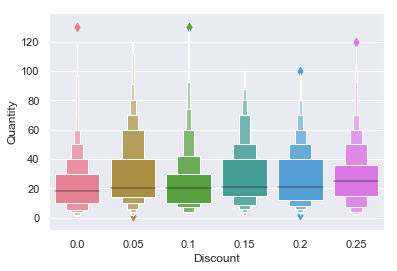

In [14]:
sns.boxenplot(dfODetails.Discount, dfODetails.Quantity)

In [15]:
dfnodiscount = dfODetails[dfODetails['Discount']==0]['Quantity']
dfdiscount = dfODetails[dfODetails['Discount']!=0]['Quantity']

In [16]:
dfnodiscount.head()

1     130
4     120
6     120
7     120
10    110
Name: Quantity, dtype: int64

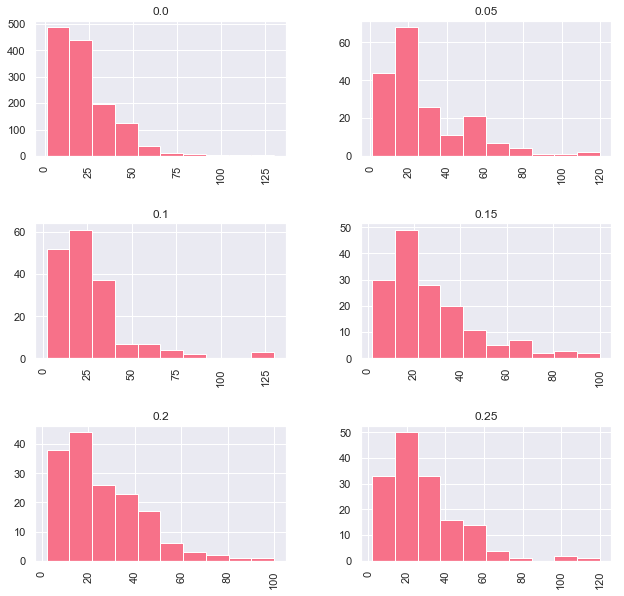

In [17]:
dfODetails.hist('Quantity', by='Discount', figsize=(10, 10));

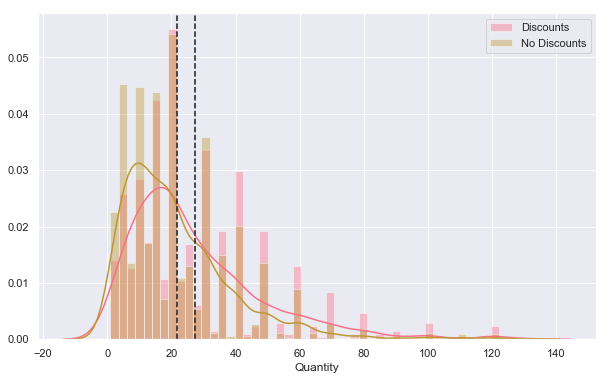

In [18]:
plt.figure(figsize=(10,6))
sns.distplot(dfdiscount, bins=50,  label='Discounts')
sns.distplot(dfnodiscount, bins=50,  label='No Discounts')

plt.axvline(x=dfnodiscount.mean(), color='k', linestyle='--')
plt.axvline(x=dfdiscount.mean(), color='k', linestyle='--')
plt.legend()

### Define Hypothesis

$H_{0}$: Offering a discount does not effect the amount of product ordered.

$H_{a}$: Offering a disount will cause customers to order more product.

This will be a **one-tail** test to test since I specified that I am specifically looking for the quantity to be _more than_ with a discount offered.


### Statistical Testing

In [19]:
print(welch_t(dfODetails.Quantity, dfdiscount))
print(welch_t(dfODetails.Quantity, dfnodiscount))

4.177518211247093
3.442289043589471


In [20]:
print('Welch_df Q/Discount: ', welch_df(dfODetails.Quantity, dfdiscount))
print('Welch_df Q/No Discount: ', welch_df(dfODetails.Quantity, dfnodiscount))
print('Welch_df No Discount/Discount: ', welch_df(dfnodiscount, dfdiscount))

Welch_df Q/Discount:  1399.0
Welch_df Q/No Discount:  2959.0
Welch_df No Discount/Discount:  1546.0


In [21]:
print('P_value: Q/Discount: ', p_value(dfODetails.Quantity, dfdiscount))
print('P_value: Q/No Discount: ',p_value(dfODetails.Quantity, dfnodiscount))
print('P_value: No Discount/Discount: ',p_value(dfnodiscount, dfdiscount))

P_value: Q/Discount:  1.564737360626456e-05
P_value: Q/No Discount:  0.0002924085768452045
P_value: No Discount/Discount:  5.025324600893555e-11


In [22]:
print(Cohen_d(dfODetails.Quantity, dfdiscount))
print(Cohen_d(dfODetails.Quantity, dfnodiscount))
print(Cohen_d(dfnodiscount, dfdiscount))

d:  -0.1773695423055324
None
d:  0.11813536855628178
None
d:  -0.29970787209408895
None


### Conclusions

Here we can see that discounts do indeed make a difference, albeit a small one, in the amount of quantity ordered when offered a discount. We can tell it is a small difference because of Cohen's D. We can also tell that offering a discount has a bigger effect size than not, beause the Cohen's D statistic is slightly larger.

## Q2: Do discounts have a greater effect on quantity of products ordered in a single transaction or the amount of total transactions?

### Exploratory Research

In [23]:
df1 = pd.read_sql_query("""SELECT od.OrderID, od.ProductID, od.Quantity, od.Discount,
                                p.ProductName, p.QuantityPerUnit, p.UnitPrice, p.UnitsOnOrder
                                FROM OrderDetail od
                                JOIN Product p ON od.ProductID = p.ID
                                WHERE od.Discount = 0.0
                                GROUP BY OrderID;""", engine)
df1.head()

,OrderId,ProductId,Quantity,Discount,ProductName,QuantityPerUnit,UnitPrice,UnitsOnOrder
0,10248,72,5,0.0,Mozzarella di Giovanni,24 - 200 g pkgs.,34.80,0
1,10249,51,40,0.0,Manjimup Dried Apples,50 - 300 g pkgs.,53.00,0
2,10250,41,10,0.0,Jack's New England Clam Chowder,12 - 12 oz cans,9.65,0
3,10251,65,20,0.0,Louisiana Fiery Hot Pepper Sauce,32 - 8 oz bottles,21.05,0
4,10252,60,40,0.0,Camembert Pierrot,15 - 300 g rounds,34.00,0


In [24]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 8 columns):
OrderId            613 non-null int64
ProductId          613 non-null int64
Quantity           613 non-null int64
Discount           613 non-null float64
ProductName        613 non-null object
QuantityPerUnit    613 non-null object
UnitPrice          613 non-null float64
UnitsOnOrder       613 non-null int64
dtypes: float64(2), int64(4), object(2)
memory usage: 38.4+ KB


In [25]:
len(df1.Quantity)

613

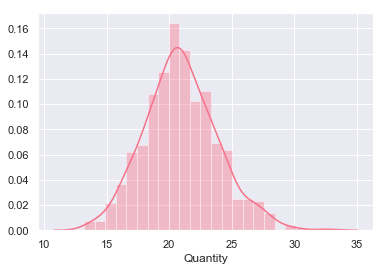

In [26]:
df1['Quantity'] = create_sample_distribution(df1['Quantity'], 613, 30)
sns.distplot(df1['Quantity']);

In [27]:
df1.describe()

,OrderId,ProductId,Quantity,Discount,UnitPrice,UnitsOnOrder
count,613.000000,613.000000,613.000000,613.0,613.000000,613.000000
mean,10659.962480,52.562806,20.957640,0.0,27.228842,6.998369
std,243.830496,19.758213,2.919131,0.0,29.484755,18.746546
min,10248.000000,1.000000,13.200000,0.0,2.500000,0.000000
25%,10444.000000,40.000000,19.033333,0.0,13.000000,0.000000
50%,10666.000000,57.000000,20.800000,0.0,19.450000,0.000000
75%,10875.000000,70.000000,22.766667,0.0,34.800000,0.000000
max,11077.000000,77.000000,32.633333,0.0,263.500000,100.000000


In [28]:
df2 = pd.read_sql_query("""SELECT od.OrderID, od.ProductID, od.Quantity, od.Discount,
                                p.ProductName, p.QuantityPerUnit, p.UnitPrice, p.UnitsOnOrder
                                FROM OrderDetail od
                                JOIN Product p ON od.ProductID = p.ID
                                WHERE od.Discount IS NOT 0.0
                                GROUP BY OrderID;""", engine)
df2.head()

,OrderId,ProductId,Quantity,Discount,ProductName,QuantityPerUnit,UnitPrice,UnitsOnOrder
0,10250,65,15,0.15,Louisiana Fiery Hot Pepper Sauce,32 - 8 oz bottles,21.05,0
1,10251,57,15,0.05,Ravioli Angelo,24 - 250 g pkgs.,19.50,0
2,10252,33,25,0.05,Geitost,500 g,2.50,0
3,10254,55,21,0.15,Pâté chinois,24 boxes x 2 pies,24.00,0
4,10258,32,6,0.20,Mascarpone Fabioli,24 - 200 g pkgs.,32.00,40


In [29]:
df2.describe()

,OrderId,ProductId,Quantity,Discount,UnitPrice,UnitsOnOrder
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,10659.555263,50.981579,27.381579,0.145684,25.570921,5.605263
std,234.869401,20.091405,22.361722,0.071868,25.257382,16.418086
min,10250.000000,1.000000,2.000000,0.010000,2.500000,0.000000
25%,10460.750000,38.000000,12.000000,0.100000,12.500000,0.000000
50%,10649.000000,55.000000,20.000000,0.150000,19.000000,0.000000
75%,10854.250000,68.000000,35.000000,0.200000,34.000000,0.000000
max,11077.000000,77.000000,130.000000,0.250000,263.500000,80.000000


In [30]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 8 columns):
OrderId            380 non-null int64
ProductId          380 non-null int64
Quantity           380 non-null int64
Discount           380 non-null float64
ProductName        380 non-null object
QuantityPerUnit    380 non-null object
UnitPrice          380 non-null float64
UnitsOnOrder       380 non-null int64
dtypes: float64(2), int64(4), object(2)
memory usage: 23.9+ KB


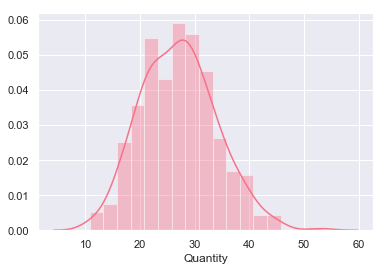

In [31]:
df2['Quantity'] = create_sample_distribution(df2['Quantity'], 380, 10)
sns.distplot(df2['Quantity']);

In [32]:
# sns.distplot(df2['Quantity'], kde=False);
# plt.axvline(0, color="k", linestyle="--");

### Define Hypothesis

$H_{0}$: Offering a discount will not have an effect on total orders.

$H_{a}$ Offering a discount will cause an increase in total orders.

This will be a one-tailed test since I am specifically looking for the discounts to cause the amount of orders placed  to be _more than_ if there were no discounts offered

### Statistical Testing

Null hypothesis is True with t-value = -2.07 , critical t-value = 1.647347241930401 and p-value = 0.0386314665


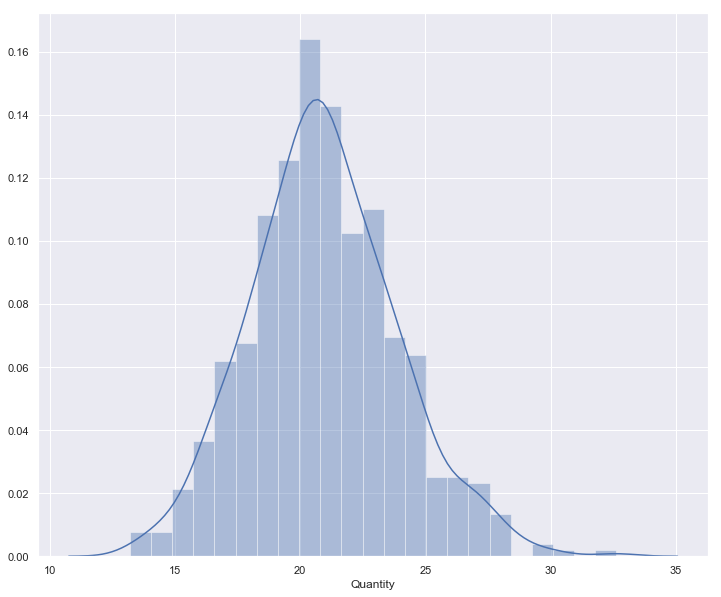

In [33]:
sample=df1.Quantity
popmean= 21.202
alpha= 0.05
one_sample_ttest(sample, popmean, alpha)

Null hypothesis is True with t-value = -0.9 , critical t-value = 1.648884031269217 and p-value = 0.3673508098


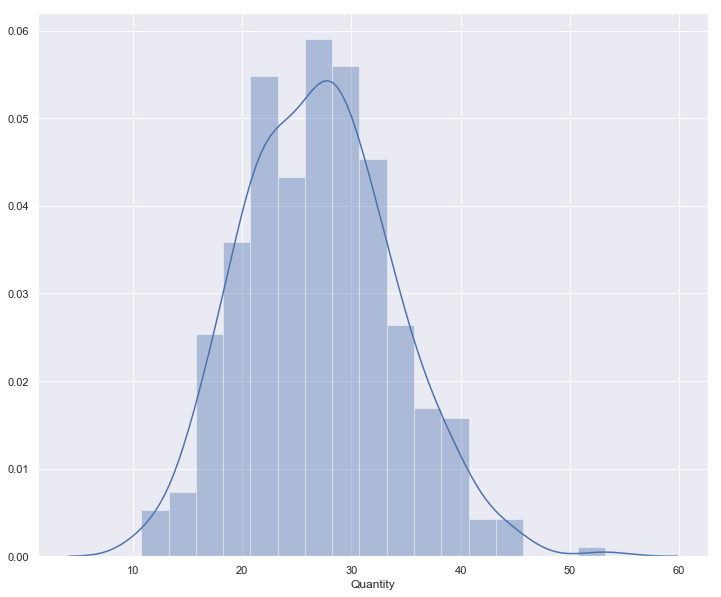

In [34]:
sample=df2.Quantity
popmean= 27.38
alpha= 0.05
one_sample_ttest(sample, popmean, alpha)

In [35]:
welch_t(df1.Quantity, df2.Quantity)

16.44767621423066

In [36]:
p_value(df1.Quantity, df2.Quantity)

0.0

In [37]:
Cohen_d(df1.Quantity, df2.Quantity)

d:  -1.2654704107632482


### Conclusions

This is the same test ran before, but with different results and I'm not sure why. The p_value is also zero which is puzzling.

## Q3: Do employees hired in different months have different productivity in sales?

### Exploratory Research

In [38]:
dfe = pd.read_sql_query("""SELECT e.ID, e.LastName, e.FirstName, e.HireDate, e.BirthDate, od.OrderID,
                                    od.UnitPrice, od.Quantity 
                                    FROM Employee e
                                    JOIN [Order] O ON e.ID = O.EmployeeID
                                    JOIN OrderDetail od ON O.ID = od.OrderID;""", con=engine)
dfe.head()

,Id,LastName,FirstName,HireDate,BirthDate,OrderId,UnitPrice,Quantity
0,5,Buchanan,Steven,2025-10-17,1987-03-04,10248,14.0,12
1,5,Buchanan,Steven,2025-10-17,1987-03-04,10248,9.8,10
2,5,Buchanan,Steven,2025-10-17,1987-03-04,10248,34.8,5
3,6,Suyama,Michael,2025-10-17,1995-07-02,10249,18.6,9
4,6,Suyama,Michael,2025-10-17,1995-07-02,10249,42.4,40


In [39]:
dfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 8 columns):
Id           2155 non-null int64
LastName     2155 non-null object
FirstName    2155 non-null object
HireDate     2155 non-null object
BirthDate    2155 non-null object
OrderId      2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
dtypes: float64(1), int64(3), object(4)
memory usage: 134.8+ KB


In [40]:
dfe['HireDate'] = pd.to_datetime(dfe['HireDate'])
dfe['BirthDate'] = pd.to_datetime(dfe['BirthDate'])

In [41]:
dfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 8 columns):
Id           2155 non-null int64
LastName     2155 non-null object
FirstName    2155 non-null object
HireDate     2155 non-null datetime64[ns]
BirthDate    2155 non-null datetime64[ns]
OrderId      2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(3), object(2)
memory usage: 134.8+ KB


In [42]:
dfe['hireday'] = pd.DatetimeIndex(dfe['HireDate']).day
dfe['hiremonth'] = pd.DatetimeIndex(dfe['HireDate']).month
dfe['hireyear'] = pd.DatetimeIndex(dfe['HireDate']).year

In [43]:
dfe.head()

,Id,LastName,FirstName,HireDate,BirthDate,OrderId,UnitPrice,Quantity,hireday,hiremonth,hireyear
0,5,Buchanan,Steven,2025-10-17,1987-03-04,10248,14.0,12,17,10,2025
1,5,Buchanan,Steven,2025-10-17,1987-03-04,10248,9.8,10,17,10,2025
2,5,Buchanan,Steven,2025-10-17,1987-03-04,10248,34.8,5,17,10,2025
3,6,Suyama,Michael,2025-10-17,1995-07-02,10249,18.6,9,17,10,2025
4,6,Suyama,Michael,2025-10-17,1995-07-02,10249,42.4,40,17,10,2025


In [44]:
dfe.hireyear.value_counts()

2024    907
2025    705
2026    543
Name: hireyear, dtype: int64

In [45]:
dfe.hiremonth.value_counts()

5     765
4     321
10    285
3     260
8     241
1     176
11    107
Name: hiremonth, dtype: int64

In [46]:
dfe.describe()

,Id,OrderId,UnitPrice,Quantity,hireday,hiremonth,hireyear
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,4.333179,10659.375870,26.218520,23.812993,6.219026,5.577726,2024.831090
std,2.490351,241.378032,29.827418,19.022047,6.169180,2.776387,0.802884
min,1.000000,10248.000000,2.000000,1.000000,1.000000,1.000000,2024.000000
25%,2.000000,10451.000000,12.000000,10.000000,1.000000,4.000000,2024.000000
50%,4.000000,10657.000000,18.400000,20.000000,3.000000,5.000000,2025.000000
75%,7.000000,10862.500000,32.000000,30.000000,14.000000,8.000000,2026.000000
max,9.000000,11077.000000,263.500000,130.000000,17.000000,11.000000,2026.000000


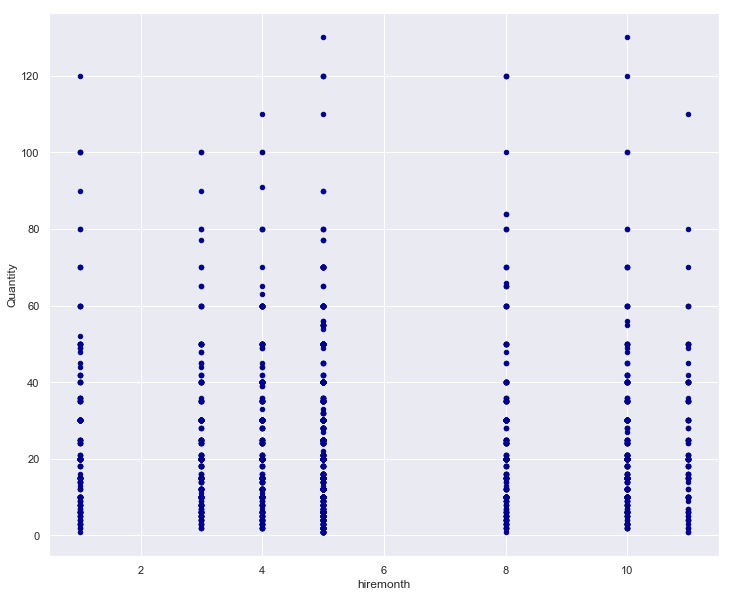

In [47]:
ax = dfe.plot.scatter(x='hiremonth', y='Quantity', c='DarkBlue')

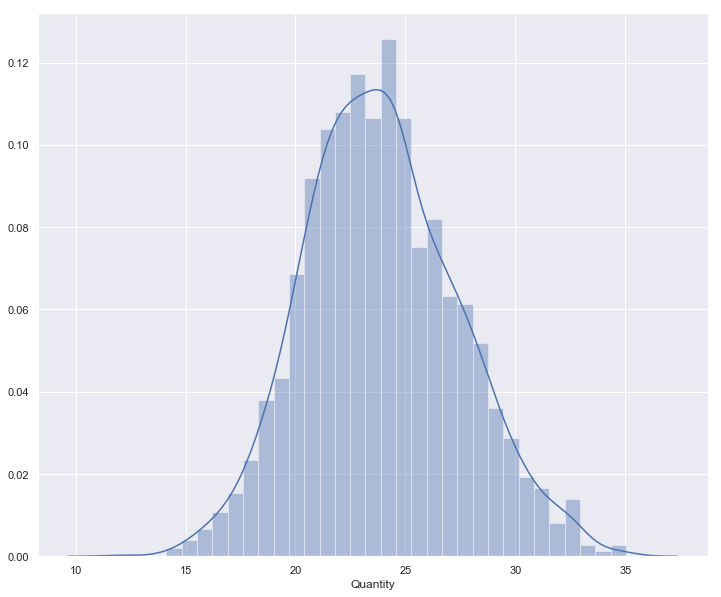

In [48]:
dfe['Quantity'] = create_sample_distribution(dfe['Quantity'], 2155, 30)
sns.distplot(dfe['Quantity']);

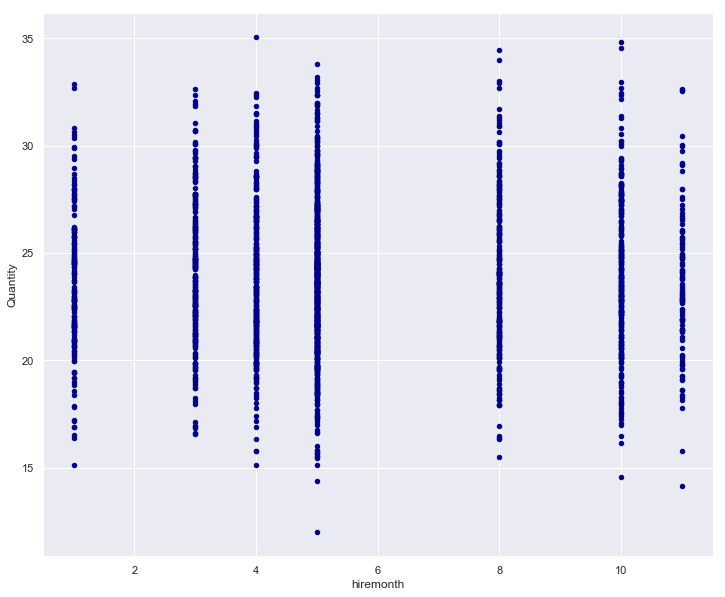

In [49]:
ax = dfe.plot.scatter(x='hiremonth', y='Quantity', c='DarkBlue')

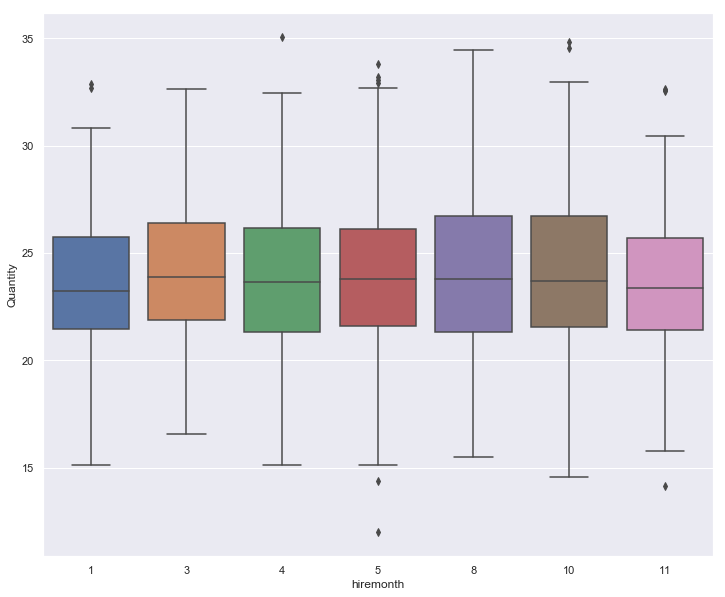

In [50]:
sns.boxplot(x=dfe.hiremonth, y=dfe.Quantity)

Text(0.5, 0, 'Hire Months')

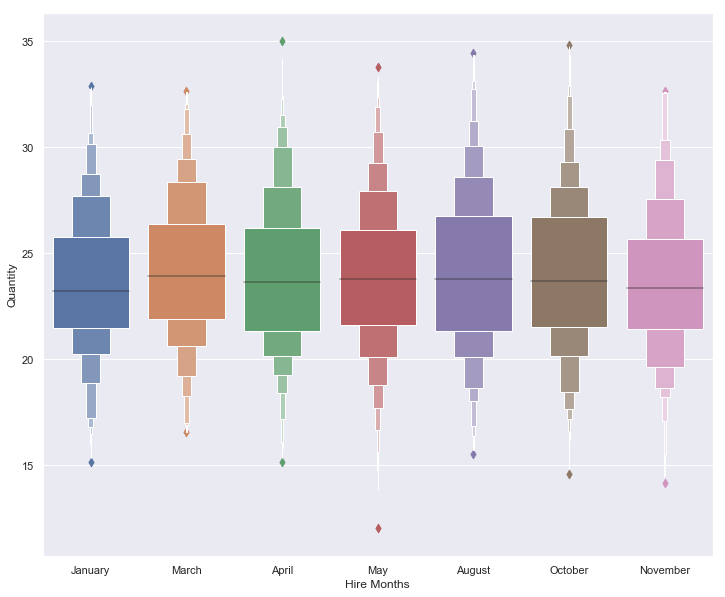

In [51]:
sns.boxenplot(dfe.hiremonth, dfe.Quantity)
positions = (0, 1, 2, 3, 4, 5, 6)
labels = ("January", "March", "April", "May", "August", "October", "November")
plt.xticks(positions, labels)
plt.xlabel("Hire Months")

### Define Hypothesis

$H_{0}$ There is no difference in productivity based on hire month.

$H_{a}$ There is a difference in productivity based on hire month.

This will be a **two-tail test** because I am testing to see if those hired in different months will sell _more than_ or _less than_ those from a different month of hire.

### Statistical Testing

In [52]:
welch_t(dfe.Quantity, dfe.hiremonth)

191.25371611872265

In [53]:
p_value(dfe.Quantity, dfe.hiremonth)

0.0

In [54]:
F, p = stats.f_oneway(dfe['Quantity'], dfe['hiremonth'])
F, p

(36577.98392922093, 0.0)

In [55]:
aov = pg.anova(data=dfe, dv='Quantity', between='hiremonth', detailed=True)
print(aov)

      Source         SS    DF      MS      F     p-unc    np2
0  hiremonth     54.123     6   9.020  0.746  0.612894  0.002
1     Within  25985.565  2148  12.098      -         -      -


In [56]:
stats.levene(dfe['Quantity'][dfe['hiremonth'] == 1],
             dfe['Quantity'][dfe['hiremonth'] == 3],
             dfe['Quantity'][dfe['hiremonth'] == 4],
             dfe['Quantity'][dfe['hiremonth'] == 5],
             dfe['Quantity'][dfe['hiremonth'] == 8],
             dfe['Quantity'][dfe['hiremonth'] == 10],
             dfe['Quantity'][dfe['hiremonth'] == 11])

LeveneResult(statistic=0.7172101292758736, pvalue=0.635751101896068)

Null hypothesis is True with t-value = 1.32 , critical t-value = 1.6455613468643528 and p-value = 0.1869865017


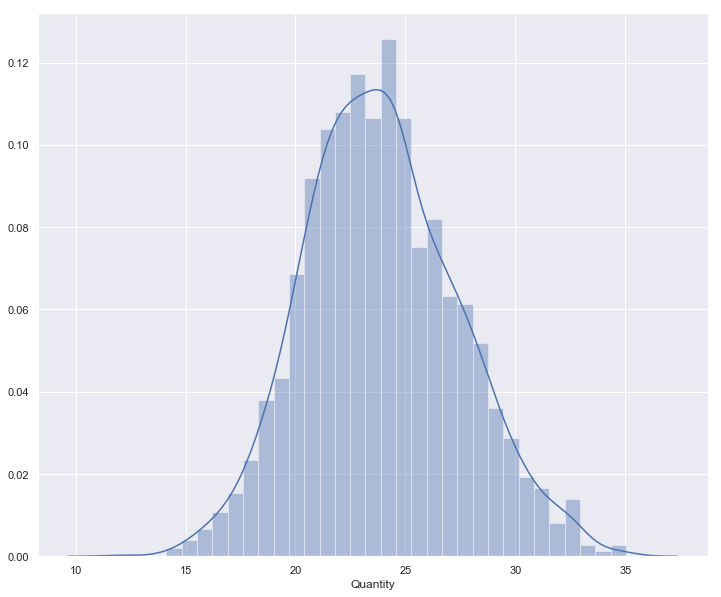

In [57]:
sample=dfe.Quantity
popmean=23.81
alpha= 0.05
one_sample_ttest(sample, popmean, alpha)

### Conclusions

I don't think I'm using the one sample t test correctly. I also don't think there's a statistical difference in hire months.

## Q4: Do younger employees sell more products than the older employees?

### Exploratory Research

In [58]:
# We're going to use the same data set as before since all our data is cleaned up already.
dfe.head()

,Id,LastName,FirstName,HireDate,BirthDate,OrderId,UnitPrice,Quantity,hireday,hiremonth,hireyear
0,5,Buchanan,Steven,2025-10-17,1987-03-04,10248,14.0,22.733333,17,10,2025
1,5,Buchanan,Steven,2025-10-17,1987-03-04,10248,9.8,23.266667,17,10,2025
2,5,Buchanan,Steven,2025-10-17,1987-03-04,10248,34.8,24.400000,17,10,2025
3,6,Suyama,Michael,2025-10-17,1995-07-02,10249,18.6,16.166667,17,10,2025
4,6,Suyama,Michael,2025-10-17,1995-07-02,10249,42.4,27.333333,17,10,2025


In [59]:
dfe['birthday'] = pd.DatetimeIndex(dfe['BirthDate']).day
dfe['birthmonth'] = pd.DatetimeIndex(dfe['BirthDate']).month
dfe['birthyear'] = pd.DatetimeIndex(dfe['BirthDate']).year

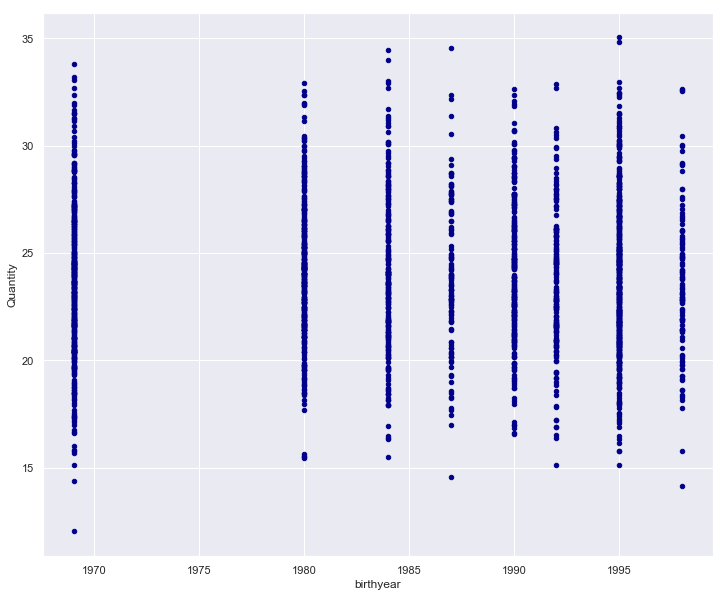

In [60]:
ax1 = dfe.plot.scatter(x='birthyear',
                        y='Quantity',
                        c='DarkBlue')

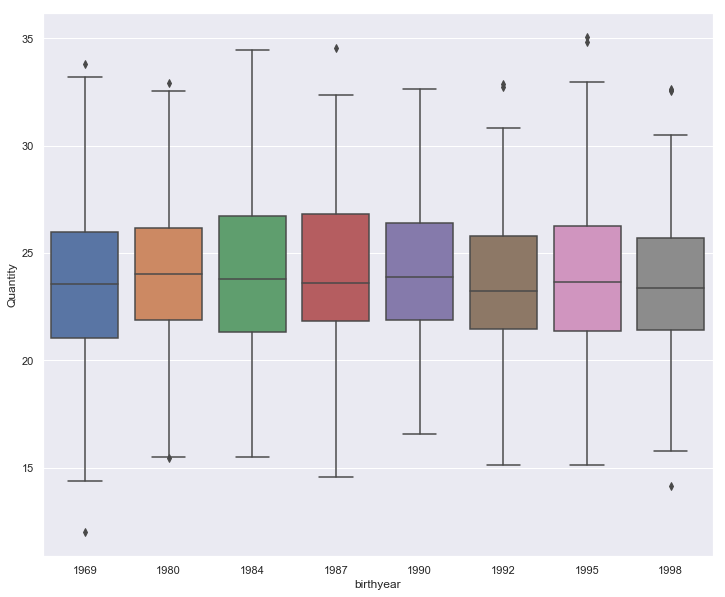

In [61]:
sns.boxplot(x=dfe.birthyear, y=dfe.Quantity)

Text(0.5, 0, 'Birth Years')

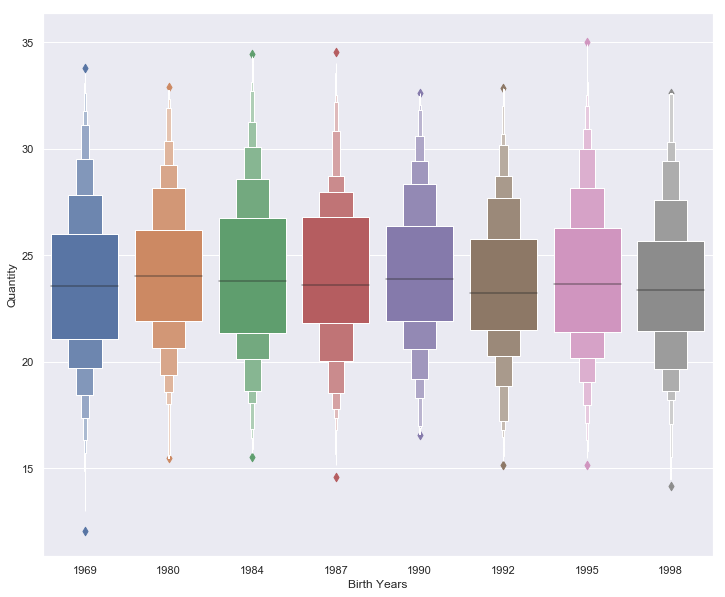

In [62]:
sns.boxenplot(dfe.birthyear, dfe.Quantity)
plt.xlabel("Birth Years")

In [63]:
dfe.birthyear.value_counts()

1995    489
1969    420
1980    345
1990    260
1984    241
1992    176
1987    117
1998    107
Name: birthyear, dtype: int64

### Define Hypothesis

$H_{0}$: There is no difference between the amount of product sold based on age.

$H_{a}$: Younger employees sell more than older employees.

This will be a **one-tail** test because I am trying to determine if the younger employees will sell _more than_ the older employees.

### Statistical Testing

In [64]:
F, p = stats.f_oneway(dfe['Quantity'], dfe['birthyear'])
F, p

(79377170.92732875, 0.0)

In [65]:
aov = pg.anova(data=dfe, dv='Quantity', between='birthyear', detailed=True)
print(aov)

      Source         SS    DF      MS      F     p-unc    np2
0  birthyear    102.625     7  14.661  1.214  0.291524  0.004
1     Within  25937.063  2147  12.081      -         -      -


In [66]:
welch_t(dfe['Quantity'], dfe['birthyear'])

8909.386675155301

In [67]:
p_value(dfe['Quantity'], dfe['birthyear'])

0.0

In [68]:
dfe.birthyear.value_counts()

1995    489
1969    420
1980    345
1990    260
1984    241
1992    176
1987    117
1998    107
Name: birthyear, dtype: int64

In [69]:
stats.levene(dfe['Quantity'][dfe['birthyear'] == 1969],
             dfe['Quantity'][dfe['birthyear'] == 1980],
             dfe['Quantity'][dfe['birthyear'] == 1984],
             dfe['Quantity'][dfe['birthyear'] == 1987],
             dfe['Quantity'][dfe['birthyear'] == 1990],
             dfe['Quantity'][dfe['birthyear'] == 1992],
             dfe['Quantity'][dfe['birthyear'] == 1995],
             dfe['Quantity'][dfe['birthyear'] == 1998])

LeveneResult(statistic=1.1704189419212492, pvalue=0.3164060323849006)

### Conclusions

The p_value for the levene test was very high, so I don't think there is a statiscially significant effect on age and quantity sold. However, I also don't know that I used this correctly so I might be wrong.

## Future Work

1. Look more into the degrees of discounts.

2. Is the company keeping too much inventory in stock for products that are sold less often or in fewer quantity?

3. Does the title of the employee change how much revenue they bring in? Do more managers/reps mean more products sold?

4. Does amount of schooling matter for products sold? (This will be based off of the Doctor title vs not.)